## How to use

In this noteboook we test the rewards given out by the protocol to different types of validators. Our `fast` config reduces the size of most constants to avoid allocating more memory than necessary (we'll only test with a few validators). We also reduce the number of slots per epoch to speed things up. All these changes are without loss of generality.

You may test various spec versions by renaming either of the `specs_*.py` files in the `beaconrunner` folder to `specs.py`. Current version tested is v1.1.0-alpha.7.

In [1]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
import beaconrunner as br

import types
from eth2spec.utils.ssz.ssz_impl import hash_tree_root

from cadCAD_tools.profiling.visualizations import visualize_substep_impact

import pandas as pd
import plotly.express as px
import plotly.io as pio
pd.options.plotting.backend = "plotly"
pio.renderers.default = "plotly_mimetype+notebook_connected"
import plotly.graph_objects as go

Below are metrics extracted from the state of the simulation. We don't really care about most of them except for `get_current_validator_state`, but they are left here for future use/reference.

In [2]:
def extract_state(s):
    validators = s["network"].validators
    validator = validators[1]
    head = br.specs.get_head(validator.store)
    current_state = validator.store.block_states[head].copy()
    return current_state

def current_slot(params, step, sL, s, _input):
    return ("current_slot", s["network"].validators[0].data.slot)

def total_balance_asap(params, step, sL, s, _input):
    validators = s["network"].validators
    current_state = extract_state(s)
    current_epoch = br.specs.get_current_epoch(current_state)
    asap_indices = [i for i, v in enumerate(validators) if v.validator_behaviour == "asap"]
    asap_balances = [b for i, b in enumerate(current_state.balances) if i in asap_indices]
    return ("total_balance_asap", sum(asap_balances))

def get_base_reward(params, step, sL, s, _input):
    current_state = extract_state(s)
    base_reward = br.specs.get_base_reward(current_state, 0)
    return ("base_reward", base_reward)

def get_block_proposer(params, step, sL, s, _input):
    current_state = extract_state(s)
    block_proposer = [v.validator_index for v in s["network"].validators if v.data.current_proposer_duties[s["current_slot"] % br.specs.SLOTS_PER_EPOCH]][0]
    return ("block_proposer", block_proposer)

def get_block_proposer_balance(params, step, sL, s, _input):
    current_state = extract_state(s)
    block_proposer_balance = current_state.balances[s["block_proposer"]]
    return ("block_proposer_balance", block_proposer_balance)

def get_sync_committee(params, step, sL, s, _input):
    current_state = extract_state(s)
    current_epoch = br.specs.get_current_epoch(current_state)
    sync_committee = current_state.current_sync_committee.pubkeys
    val_pubkeys = [v.pubkey for v in current_state.validators]
    sync_committee_indices = [val_pubkeys.index(pubkey) for pubkey in sync_comittee]
    return ("sync_committee", sync_committee_indices)

def get_head(params, step, sL, s, _input):
    validators = s["network"].validators
    validator = validators[0]
    head = br.specs.get_head(validator.store).hex()[0:6]
    return ("head", head)

def get_current_validator_state(params, step, sL, s, _input):
    current_state = extract_state(s)
    current_validator_state = []
    for v in s["network"].validators:
        current_validator_state += [{
            "slot": v.data.slot,
            "validator_index": v.validator_index,
            "balance": current_state.balances[v.validator_index],
            "block_proposer": 1 if s["block_proposer"] == v.validator_index else 0,
            "attester": 1 if v.data.current_attest_slot == v.data.slot else 0,
            "sync_committee": len(v.data.current_sync_committee),
        }]
    return ("current_validator_state", current_validator_state)

observers = {
    "current_slot": current_slot,
    "total_balance_asap": total_balance_asap,
    "base_reward": get_base_reward,
    "block_proposer": get_block_proposer,
    "block_proposer_balance": get_block_proposer_balance,
#     "sync_committee": get_sync_committee,
    "head": get_head,
    "current_validator_state": get_current_validator_state,
}

Run the simulation.

In [3]:
from random import sample
from beaconrunner.validators.ASAPValidator import ASAPValidator

num_validators = 20

# Initiate validators
validators = []
for i in range(num_validators):
    new_validator = ASAPValidator(i)
    validators.append(new_validator)

# Create a genesis state
(genesis_state, genesis_block) = br.simulator.get_genesis_state_block(validators)

# Validators load the state
[v.load_state(genesis_state.copy(), genesis_block.copy()) for v in validators]

# We skip the genesis block
br.simulator.skip_genesis_block(validators)
# print(genesis_state)

# Create the network
set_a = br.network.NetworkSet(validators=list(range(num_validators)))
network_sets = list([set_a])
network = br.network.Network(validators = validators, sets = network_sets)

# Set simulation parameters
parameters = br.simulator.SimulationParameters({
    "num_epochs": 4,
    "run_index": 1,
    "frequency": 1,
    "network_update_rate": 1.0,
})

df = br.simulator.simulate(network, parameters, observers) 

INFO:root:Starting simulation 0 / run 0 / subset 0


will simulate 4 epochs ( 16 slots ) at frequency 1 moves/second
total 192 simulation steps
19 proposing block for slot 1
6 proposing block for slot 2
7 proposing block for slot 3
14 proposing block for slot 4
9 proposing block for slot 5
10 proposing block for slot 6
0 proposing block for slot 7
10 proposing block for slot 8
13 proposing block for slot 9
timestep 100 of run 1
18 proposing block for slot 10
3 proposing block for slot 11
0 proposing block for slot 12
2 proposing block for slot 13
3 proposing block for slot 14
12 proposing block for slot 15
11 proposing block for slot 16


In [4]:
df = df.drop(columns=['network'])

We collect the validator state data in a separate dataframe, of schema `(slot, validator_index, balance, block_proposer, attester, sync_committee)`. We ignore the first few epochs (rewards aren't given out, or imperfectly) and make sure the key `(slot, validator_index)` is unique.

In [5]:
df

,current_slot,total_balance_asap,base_reward,block_proposer,block_proposer_balance,head,current_validator_state,run_time,simulation,subset,run,substep,timestep,substep_label
0,1,640000000000,2560000,19,32000000000,168f82,"[{'slot': 1, 'validator_index': 0, 'balance': ...",0.000000e+00,0,0,1,0,0,Initial State
1,1,640000000000,2560000,19,32000000000,168f82,"[{'slot': 1, 'validator_index': 0, 'balance': ...",1.626053e+09,0,0,1,1,1,Initial measure runtime
2,1,640000000000,2560000,19,32000000000,168f82,"[{'slot': 1, 'validator_index': 0, 'balance': ...",1.626053e+09,0,0,1,2,1,Attestations
3,1,640000000000,2560000,19,32000000000,168f82,"[{'slot': 1, 'validator_index': 0, 'balance': ...",1.626053e+09,0,0,1,3,1,Measure runtime 0
4,1,640000000000,2560000,19,32000000000,168f82,"[{'slot': 1, 'validator_index': 0, 'balance': ...",1.626053e+09,0,0,1,4,1,Sync committee
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724,16,640132299955,2560000,11,32004319997,0aea1b,"[{'slot': 16, 'validator_index': 0, 'balance':...",1.626053e+09,0,0,1,5,192,Measure runtime 1
1725,16,640132299955,2560000,11,32004319997,0aea1b,"[{'slot': 16, 'validator_index': 0, 'balance':...",1.626053e+09,0,0,1,6,192,Block proposals
1726,16,640132299955,2560000,11,32004319997,0aea1b,"[{'slot': 16, 'validator_index': 0, 'balance':...",1.626053e+09,0,0,1,7,192,Measure runtime 2
1727,17,640132299955,2560000,11,32004319997,0aea1b,"[{'slot': 17, 'validator_index': 0, 'balance':...",1.626053e+09,0,0,1,8,192,Simulation tick


  0%|          | 0/192 [00:00<?, ?it/s]

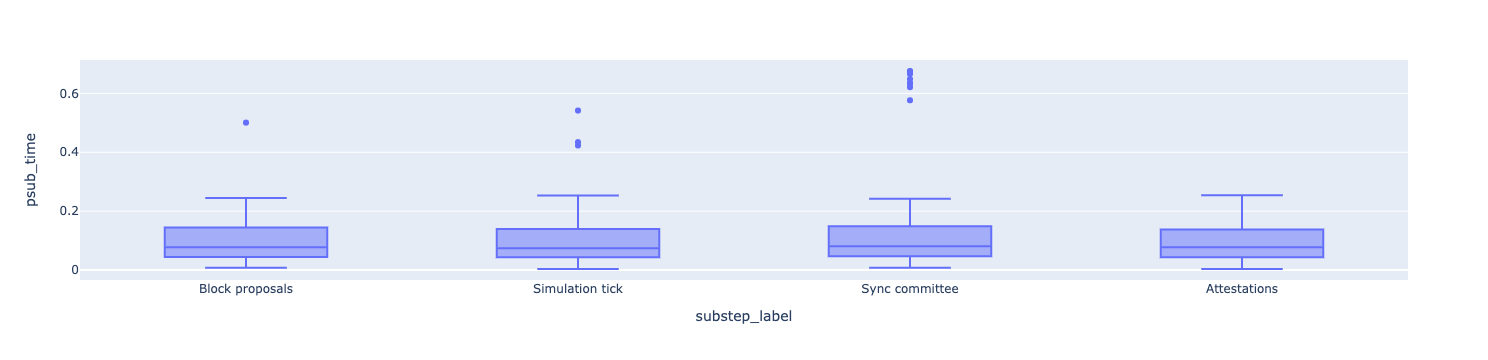

In [6]:
visualize_substep_impact(df, relative=False)

In [7]:
import itertools
import pandas as pd
pd.set_option('display.max_rows', 100)
validator_df = pd.DataFrame(
    itertools.chain(*df[((df.substep == 0) | (df.substep == max(df.substep))) & (df.timestep % 12 == 1) & (df.current_slot > 11)]["current_validator_state"].iloc[:])
)
validator_df["previous_balance"] = validator_df.groupby(["validator_index"])[["balance"]].shift()
validator_df["balance_diff"] = validator_df["balance"] - validator_df["previous_balance"]
validator_df = validator_df[validator_df.slot > 12]

## Obtaining rewards per duty

We isolate validators who occupied a unique role over a slot to obtain the rewards for block proposers and sync committee members. When rewards are given out during the epoch transition, the minimum received by any validator is received by a validator who neither proposed a block for the whole epoch and was never part of the sync committee, giving us the attester reward received by one validator.

In [8]:
block_proposer_reward = validator_df[(validator_df.block_proposer == 1) & (validator_df.sync_committee == 0)].iloc[0]["balance_diff"]
print(f"block proposer reward = {block_proposer_reward}")

block proposer reward = 1599997.0


In [9]:
attester_reward = min(validator_df[validator_df.slot % br.specs.SLOTS_PER_EPOCH == 0]["balance_diff"])
print(f"attester reward = {attester_reward}")

attester reward = 2160000.0


In [10]:
sync_committee_reward = validator_df[(validator_df.block_proposer == 0) & (validator_df.sync_committee == 1)].iloc[0]["balance_diff"]
print(f"sync committee reward = {sync_committee_reward}")

sync committee reward = 100000.0


In [11]:
base_reward = df.iloc[0]["base_reward"]
print(f"base reward = {base_reward}")

base reward = 2560000


Make our checks.

In [12]:
total_per_epoch = num_validators * base_reward
total_for_proposers = int(br.specs.SLOTS_PER_EPOCH) * block_proposer_reward
expected_proposers = float(br.specs.PROPOSER_WEIGHT) / br.specs.WEIGHT_DENOMINATOR

total_for_attesters = num_validators * attester_reward
expected_attesters = float(br.specs.TIMELY_SOURCE_WEIGHT + br.specs.TIMELY_TARGET_WEIGHT + br.specs.TIMELY_HEAD_WEIGHT) / br.specs.WEIGHT_DENOMINATOR

total_for_sync_committee = int(br.specs.SLOTS_PER_EPOCH) * int(br.specs.SYNC_COMMITTEE_SIZE) * sync_committee_reward
expected_sync = float(br.specs.SYNC_REWARD_WEIGHT) / br.specs.WEIGHT_DENOMINATOR

print(f"expected total per epoch = {total_per_epoch} vs. realised total = {total_for_proposers + total_for_attesters + total_for_sync_committee}")
print(f"percent of attester rewards = {total_for_attesters / total_per_epoch}, expected {expected_attesters}")
print(f"percent of sync committee rewards = {total_for_sync_committee / total_per_epoch}, expected {expected_sync}")
print(f"percent of block proposer rewards = {total_for_proposers / total_per_epoch}, expected {expected_proposers}")

expected total per epoch = 51200000 vs. realised total = 51199988.0
percent of attester rewards = 0.84375, expected 0.84375
percent of sync committee rewards = 0.03125, expected 0.03125
percent of block proposer rewards = 0.124999765625, expected 0.125
